# Generative Adversial Network (GAN) model

## Шаардлагатай сангуудаа оруулах

In [1]:
import os
import glob

import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import tensorflow as tf
from keras import layers, models, losses
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

import time

## Өгөгдлөө унших

In [2]:
dataset = pd.read_csv("../input/data.csv")

### Өгөгдлөө харах

In [3]:
display(dataset.head().T, dataset.shape)

,0,1,2,3,4
320,-1.388896,16.722093,0.329687,-10.598846,10.015236
321,0.05821,-1.186429,-0.747993,-5.978379,12.575455
322,5.898464,-10.186022,-1.588051,1.822014,13.012607
323,5.849397,-3.832706,0.152671,12.90642,13.932454
324,2.37903,12.73007,5.357345,21.049637,13.677982
...,...,...,...,...,...
1648,1.384356,-4.633642,-5.380405,10.001486,35.561525
1649,16.59277,-6.431111,-6.852814,1.22302,37.348663
1650,8.760738,25.847542,-2.682321,1.914469,11.53166
Diagnostic,Streptavidin,Streptavidin,Streptavidin,S,S


(89, 1333)

## Өгөгдлийн урьдчилсан боловсруулалт

In [4]:
def data_preprocessing_bin(dataset):

    X = dataset.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
    X.columns = X.columns.astype(int)
    y = dataset['COVID-19_Status']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

In [5]:
X_train, X_test, y_train_encoded, y_test_encoded = data_preprocessing_bin(dataset)

## GAN загвар

### The Generator model (Үүсгэгч загвар)

In [6]:
noise_dim = 100            
feature_dim = X_train.shape[1]

In [7]:
def make_generator_model():
    model = Sequential()
    model.add(layers.Input((noise_dim)))

    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(layers.Dense(256, activation="leaky_relu"))    
    model.add(layers.Dense(feature_dim))
    model.compile()
    
    print(model.output_shape)
    assert model.output_shape == (None, feature_dim)               

    return model

In [8]:
generator = make_generator_model()
generator.summary()

(None, 1331)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1331)              342067    
                                                                 
Total params: 388531 (1.48 MB)
Trainable params: 388275 (1.48 MB)
Non-trainable params: 256 (1.00 KB)
_______

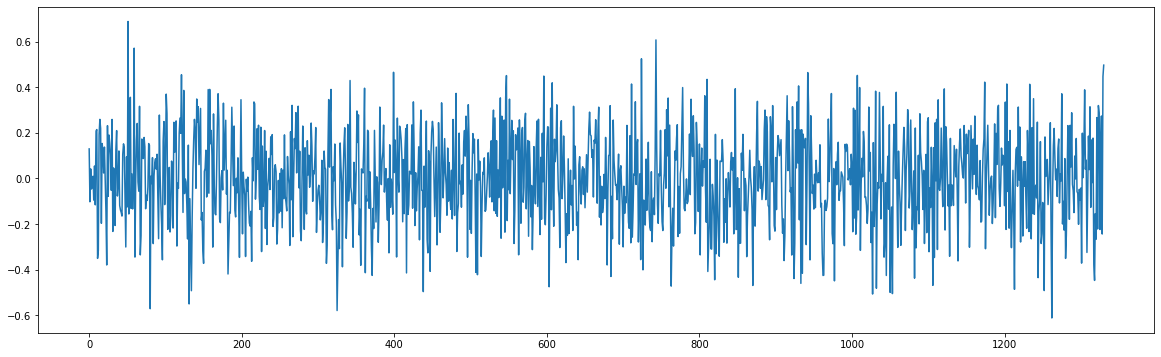

In [27]:
noise = tf.random.normal([1, noise_dim])
generated_data = generator(noise, training=False)
generated_data_ = generated_data.numpy().reshape(-1).tolist()
plt.figure(figsize=(20,6))
plt.plot(generated_data_)
plt.savefig('../figures/LatentNoise_2024_Winter.png', dpi=600, bbox_inches='tight', transparent=True)


In [16]:
def make_discriminator_model():
    
    model = Sequential()
    
    model.add(layers.Input(shape= (feature_dim)))
    model.add(layers.Reshape([feature_dim, 1]))
    model.add(layers.Conv1D(kernel_size= 15, filters= 256, activation='leaky_relu'))
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv1D(kernel_size= 15, filters= 128)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.2))      

    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.compile()
    
    return model

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_data)
print (decision)
generator.summary()

tf.Tensor([[-0.01495717]], shape=(1, 1), dtype=float32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1331)              342067    
                                                                 
Total params: 388531 (1.48 MB)
Trainable params: 388275 (1.48 MB)


### Loss function болон Optimizer

In [18]:
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

# Definining the discriminator loss

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

# Defining the generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# Defining training optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [20]:
# Model checkpoints saving

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [21]:
seed = tf.random.normal([1, noise_dim])         

def draw_training_evolution(model, epoch, noise_input= seed):
  """
    Function that takes in the generator model, epoch number, and 
    does a prediction and plots the generated singal then saves it.
  """
  # `training` is set to False.
  # Thus, all layers run in inference mode (batchnorm).
  predictions = model(noise_input, training=False)
  
  for i in range(predictions.shape[0]):
    fig = plt.figure()
    plt.plot(predictions[i].numpy().tolist())
    plt.savefig('output/evolution/image_at_epoch_{:04d}_{:04d}.png'.format(epoch, i))
    plt.close()

def generate_data(model, num_synthetic_to_gen=1):
  """
    Function that takes in the generator model and 
    does a prediction and returns it as a numpy array.
  """
  noise_input = tf.random.normal([num_synthetic_to_gen, noise_dim])
  predictions = model(noise_input, training=False)
  predictions = predictions.numpy()
  return predictions

def calc_accuracy(prediction):
  """
    Function that takes in the some data judgements 
    from the discriminator and get the average of 
    judgements that indicate how the discriminator is fooled.
  """
  prediction_clipped = tf.clip_by_value(prediction, 0.0, 1.0, name=None)
  return tf.reduce_mean(prediction_clipped)

In [22]:
BATCH_SIZE = 4 

In [23]:
# `tf.function` # This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    """
      Function for implementing one training step 
      of the GAN model
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim], seed=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_data = generator(noise, training=True)

      real_output = discriminator(data, training=True)
      fake_output = discriminator(generated_data, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      acc = calc_accuracy(fake_output)
     
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, acc

In [24]:
numofEPOCHS = 10000

In [25]:
def train(dataset, epochs):
  """
    Main GAN Training Function
  """
  epochs_gen_losses, epochs_disc_losses, epochs_accuracies = [], [], []

  for epoch in range(epochs):
    start = time.time()

    gen_losses, disc_losses, accuracies = [], [], []

    for data_batch in dataset:
      gen_loss, disc_loss, acc = train_step(data_batch)
      accuracies.append(acc)
      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    epoch_gen_loss  = np.average(gen_losses)
    epoch_disc_loss = np.average(disc_losses)
    epoch_accuracy = np.average(accuracies)
    epochs_gen_losses.append(epoch_gen_loss)
    epochs_disc_losses.append(epoch_disc_loss)
    epochs_accuracies.append(epoch_accuracy)
    print("Epoch: {}/{}".format(epoch+1, epochs))
    print("Generator Loss: {}, Discriminator Loss: {}".format(epoch_gen_loss, epoch_disc_loss))
    print("Accuracy: {}".format(epoch_accuracy))
      
    # Draw the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      draw_training_evolution(generator, epoch+1)
        
    # Save the model every 2 epochs for the last 2000 epochs
    if (epoch + 1) % 2 == 0 and epoch > (numofEPOCHS - 2000):
      checkpoint.save(file_prefix = checkpoint_prefix)   # Comment not to save model checkpoints while training
      

  return epochs_gen_losses, epochs_disc_losses, epochs_accuracies  

In [26]:
EPOCHS = numofEPOCHS

epochs_gen_losses, epochs_disc_losses, epochs_accuracies = train(X_train, EPOCHS)

ValueError: in user code:

    File "C:\Users\lemon\AppData\Local\Temp\ipykernel_4500\2606539796.py", line 13, in train_step  *
        real_output = discriminator(data, training=True)
    File "c:\Users\lemon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'reshape' (type Reshape).
    
    slice index 0 of dimension 0 out of bounds. for '{{node sequential_1/reshape/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](sequential_1/reshape/Shape, sequential_1/reshape/strided_slice/stack, sequential_1/reshape/strided_slice/stack_1, sequential_1/reshape/strided_slice/stack_2)' with input shapes: [0], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.
    
    Call arguments received by layer 'reshape' (type Reshape):
      • inputs=tf.Tensor(shape=(), dtype=float32)
